## Setup

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
        .master("local[2]")\
        .appName("spark_analysis")\
        .config('spark-master', '7077')\
        .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/02 13:56:13 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## Data reader

In [2]:
from pyspark import SparkContext
from pyspark.sql import functions as func
from pyspark.sql import *
from pyspark.sql.window import Window

In [3]:
# Đọc dữ liệu 
df = spark.read.csv('hdfs://namenode:9000/Input_data/data_preprocessed.csv', escape = "\"", header = True, inferSchema=True,multiLine=True)
df.show(5)

22/01/02 13:56:37 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+--------------------+--------------------+-------+---------+--------------------+--------------------+--------+---------+--------------+-------+------------+---------+--------+--------------------+---------+--------------+--------------------+----------+------------+--------+---------+---------+----------+--------------------+-----------+--------------------+-----------------+
|                 Tên|               Mô tả|Mức giá|Diện tích|       Loại tin đăng|             Địa chỉ|Mặt tiền|Đường vào|Hướng ban công|Số tầng|Số phòng ngủ|Số toilet|Nội thất|             Pháp lý|Tên dự án|    Chủ đầu tư|              Quy mô| Ngày đăng|Ngày hết hạn|  Mã tin|Phòng ngủ|Hướng nhà|  Loại tin|                 url|       Tỉnh|          Quận/Huyện|Mức giá/Diện tích|
+--------------------+--------------------+-------+---------+--------------------+--------------------+--------+---------+--------------+-------+------------+---------+--------+--------------------+---------+--------------+---------------

## Analysis price

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import math

def visualize_bar_chart(labels, bars, x_tick = None, title = '', x_axis= '', y_axis = '', figsize = (15,8), rotation=False):
  plt.figure(figsize = figsize)

  ind = np.arange(len(bars[0]))

  w = round(float(0.9/len(bars)),1)
  if rotation:
    for i, (bar, label) in enumerate(zip(bars,labels)):
      plt.barh(ind+w*(i-round(len(bars)/2)),bar,height=w,align='center', label = label)
      plt.yticks(ind, x_tick)
  else:
    for i, (bar, label) in enumerate(zip(bars,labels)):
      plt.bar(ind+w*(i-round(len(bars)/2)),bar,width=w,align='center', label = label)
      
      plt.xticks(ind, x_tick)
  #if x_tick is not None:
  #  if rotation:
  #    plt.xticks(ind, x_tick, rotation='vertical')
  #  else:
  #    plt.xticks(ind, x_tick)
  #yticks(xrange(10), rotation='vertical')
  
  plt.xlabel(x_axis)
  plt.ylabel(y_axis)
  plt.title(title)
  plt.legend()
  plt.show()

In [5]:
# Thống kê loại tin
news_type = df.groupby("Loại tin đăng")\
             .agg(func.count("Loại tin đăng").alias("Số lượng tin"))
news_type = news_type\
  .withColumn("Tỉ lệ tin(%)", func.col("Số lượng tin")/func.sum("Số lượng tin").over(Window.partitionBy())*100)
news_type = news_type\
  .withColumn("Tỉ lệ tin(%)", func.round(news_type["Tỉ lệ tin(%)"], 2))

In [6]:
news_type.sort("Số lượng tin", ascending=False)\
         .show()

22/01/02 13:57:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/01/02 13:57:11 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/01/02 13:57:16 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/01/02 13:57:17 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+--------------------+------------+------------+
|       Loại tin đăng|Số lượng tin|Tỉ lệ tin(%)|
+--------------------+------------+------------+
|             Bán đất|       46048|       25.26|
|       Bán nhà riêng|       41841|       22.95|
| Bán căn hộ chung cư|       36194|       19.85|
|Bán nhà mặt phố (...|       23939|       13.13|
|Bán nhà biệt thự,...|       16523|        9.06|
|Bán đất nền dự án...|       15514|        8.51|
|Bán loại bất động...|         972|        0.53|
|  Bán kho, nhà xưởng|         669|        0.37|
|Bán trang trại, k...|         477|        0.26|
|        Bán condotel|         143|        0.08|
+--------------------+------------+------------+



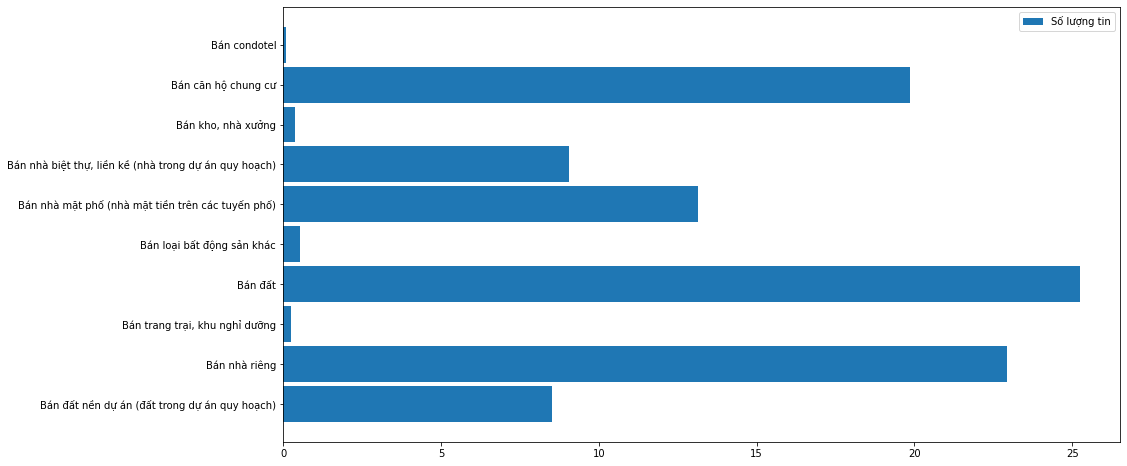

In [8]:
visualize_df = news_type.toPandas()
visualize_bar_chart(['Số lượng tin'], [list(visualize_df['Tỉ lệ tin(%)'])], list(visualize_df['Loại tin đăng']), rotation=True)

In [9]:
# Phân tích chung cho từng tỉnh
province_df = df.filter((df["Diện tích"].isNotNull()) & (df["Tỉnh"].isNotNull())\
                        & (df["Mức giá/Diện tích"] > 0.1) & (df["Mức giá/Diện tích"] < 10000))\
                .groupby("Tỉnh")\
                .agg(func.mean("Diện tích").alias("Diện tích đất trung bình(m^2)"),\
                    func.mean("Mức giá").alias("Mức giá đất trung bình(triệu VNĐ)"),\
                    func.mean("Mức giá/Diện tích").alias("Giá trị trung bình của 1 m^2(triệu VNĐ)"),\
                    func.count("Diện tích").alias("Số lượng tin"))
province_df = province_df\
              .withColumn("Giá trị trung bình của 1 m^2(triệu VNĐ)", func.round(province_df["Giá trị trung bình của 1 m^2(triệu VNĐ)"], 2))\
              .withColumn("Diện tích đất trung bình(m^2)", func.round(province_df["Diện tích đất trung bình(m^2)"], 2))\
              .withColumn("Mức giá đất trung bình(triệu VNĐ)", func.round(province_df["Mức giá đất trung bình(triệu VNĐ)"], 2))\
              .withColumn("Tỉ lệ tin(%)", func.col("Số lượng tin")/func.sum("Số lượng tin").over(Window.partitionBy())*100)
province_df = province_df\
              .withColumn("Tỉ lệ tin(%)", func.round(province_df["Tỉ lệ tin(%)"], 2))

In [10]:
province_df.sort("Diện tích đất trung bình(m^2)", ascending=False)\
           .show()

22/01/02 13:59:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/01/02 13:59:41 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/01/02 13:59:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/01/02 13:59:47 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+----------+-----------------------------+---------------------------------+---------------------------------------+------------+------------+
|      Tỉnh|Diện tích đất trung bình(m^2)|Mức giá đất trung bình(triệu VNĐ)|Giá trị trung bình của 1 m^2(triệu VNĐ)|Số lượng tin|Tỉ lệ tin(%)|
+----------+-----------------------------+---------------------------------+---------------------------------------+------------+------------+
|  Nam Định|                     23139.93|                         18540.98|                                  30.45|          45|        0.03|
|  Đắk Nông|                      16851.5|                           3960.0|                                   1.55|          22|        0.01|
| Hải Dương|                      5668.65|                          6711.83|                                   15.3|          44|        0.03|
|  Hòa Bình|                      5223.89|                          5115.34|                                   7.68|         449|        0.29|

22/01/02 14:00:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/01/02 14:00:01 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/01/02 14:00:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
22/01/02 14:00:06 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


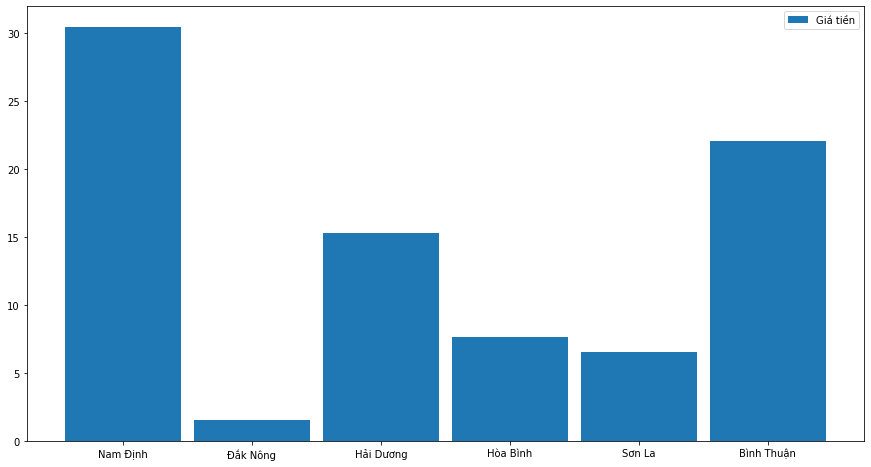

In [12]:
visualize_df = province_df.sort("Diện tích đất trung bình(m^2)", ascending=False).limit(6).toPandas()
visualize_bar_chart(['Giá tiền'], [list(visualize_df['Giá trị trung bình của 1 m^2(triệu VNĐ)'])], list(visualize_df['Tỉnh']), rotation=False)

In [ ]:
# Phân tích chi tiết từng tỉnh
detail_province_df = df.filter(df["Mức giá/Diện tích"].isNotNull() & df["Tỉnh"].isNotNull()\
                               & (df["Mức giá/Diện tích"] > 0.1) & (df["Mức giá/Diện tích"] < 10000))\
                       .groupBy("Tỉnh","Loại tin đăng")\
                       .agg(func.mean("Diện tích").alias("Diện tích đất trung bình(m^2)"),\
                            func.max("Diện tích").alias("Diện tích đất lớn nhất(m^2)"),\
                            func.min("Diện tích").alias("Diện tích đất nhỏ nhất(m^2)"),\
                            func.mean("Mức giá").alias("Mức giá đất trung bình(triệu VNĐ)"),\
                            func.max("Mức giá").alias("Mức giá đất lớn nhất(triệu VNĐ)"),\
                            func.min("Mức giá").alias("Mức giá đất nhỏ nhất(triệu VNĐ)"),\
                            func.mean("Mức giá/Diện tích").alias("Giá trị trung bình của 1 m^2(triệu VNĐ)"),\
                            func.max("Mức giá/Diện tích").alias("Giá trị cao nhất của 1 m^2(triệu VNĐ)"),\
                            func.min("Mức giá/Diện tích").alias("Giá trị thấp nhất của 1 m^2(triệu VNĐ)"),\
                            func.count("Mã tin").alias("Số lượng tin"))
detail_province_df = detail_province_df\
                    .withColumn("Giá trị trung bình của 1 m^2(triệu VNĐ)", func.round(detail_province_df["Giá trị trung bình của 1 m^2(triệu VNĐ)"], 2))\
                    .withColumn("Diện tích đất trung bình(m^2)", func.round(detail_province_df["Diện tích đất trung bình(m^2)"], 2))\
                    .withColumn("Mức giá đất trung bình(triệu VNĐ)", func.round(detail_province_df["Mức giá đất trung bình(triệu VNĐ)"], 2))\
                    .withColumn("Tỉ lệ tin(%)", func.col("Số lượng tin")/func.sum("Số lượng tin").over(Window.partitionBy())*100)
detail_province_df = detail_province_df\
                    .withColumn("Tỉ lệ tin(%)", func.round(detail_province_df["Tỉ lệ tin(%)"], 2))


In [ ]:
detail_province_df.sort("Giá trị trung bình của 1 m^2(triệu VNĐ)", ascending = False)\
                  .show()

In [ ]:
# Phân tích chi tiết từng quận ở 1 tỉnh
PROVINCE = "Hà Nội"
TYPE = "Bán nhà mặt phố"

district_price = df.filter(df["Mức giá/Diện tích"].isNotNull() & (df["Tỉnh"] == PROVINCE)\
                            & (df["Mức giá/Diện tích"] > 0.1) & (df["Mức giá/Diện tích"] < 10000) & (df["Loại tin đăng"].startswith(TYPE)))\
                   .groupby("Quận/Huyện","Loại tin đăng")\
                   .agg(func.mean("Diện tích").alias("Diện tích đất trung bình(m^2)"),\
                        func.max("Diện tích").alias("Diện tích đất lớn nhất(m^2)"),\
                        func.min("Diện tích").alias("Diện tích đất nhỏ nhất(m^2)"),\
                        func.mean("Mức giá").alias("Mức giá đất trung bình(triệu VNĐ)"),\
                        func.max("Mức giá").alias("Mức giá đất lớn nhất(triệu VNĐ)"),\
                        func.min("Mức giá").alias("Mức giá đất nhỏ nhất(triệu VNĐ)"),\
                        func.mean("Mức giá/Diện tích").alias("Giá trị trung bình của 1 m^2(triệu VNĐ)"),\
                        func.max("Mức giá/Diện tích").alias("Giá trị cao nhất của 1 m^2(triệu VNĐ)"),\
                        func.min("Mức giá/Diện tích").alias("Giá trị thấp nhất của 1 m^2(triệu VNĐ)"),\
                        func.count("Mã tin").alias("Số lượng tin"))
district_price = district_price\
  .withColumn("Giá trị trung bình của 1 m^2(triệu VNĐ)", func.round(district_price["Giá trị trung bình của 1 m^2(triệu VNĐ)"], 2))\
  .withColumn("Diện tích đất trung bình(m^2)", func.round(district_price["Diện tích đất trung bình(m^2)"], 2))\
  .withColumn("Mức giá đất trung bình(triệu VNĐ)", func.round(district_price["Mức giá đất trung bình(triệu VNĐ)"], 2))\
  .withColumn("Tỉ lệ tin(%)", func.col("Số lượng tin")/func.sum("Số lượng tin").over(Window.partitionBy())*100)
district_price = district_price\
  .withColumn("Tỉ lệ tin(%)", func.round(district_price["Tỉ lệ tin(%)"], 2))

In [ ]:
district_price.sort("Giá trị trung bình của 1 m^2(triệu VNĐ)", ascending = False)\
              .show()

+-----------------+--------------------+-----------------------------+---------------------------+---------------------------+---------------------------------+-------------------------------+-------------------------------+---------------------------------------+-------------------------------------+--------------------------------------+------------+------------+
|       Quận/Huyện|       Loại tin đăng|Diện tích đất trung bình(m^2)|Diện tích đất lớn nhất(m^2)|Diện tích đất nhỏ nhất(m^2)|Mức giá đất trung bình(triệu VNĐ)|Mức giá đất lớn nhất(triệu VNĐ)|Mức giá đất nhỏ nhất(triệu VNĐ)|Giá trị trung bình của 1 m^2(triệu VNĐ)|Giá trị cao nhất của 1 m^2(triệu VNĐ)|Giá trị thấp nhất của 1 m^2(triệu VNĐ)|Số lượng tin|Tỉ lệ tin(%)|
+-----------------+--------------------+-----------------------------+---------------------------+---------------------------+---------------------------------+-------------------------------+-------------------------------+---------------------------------------+

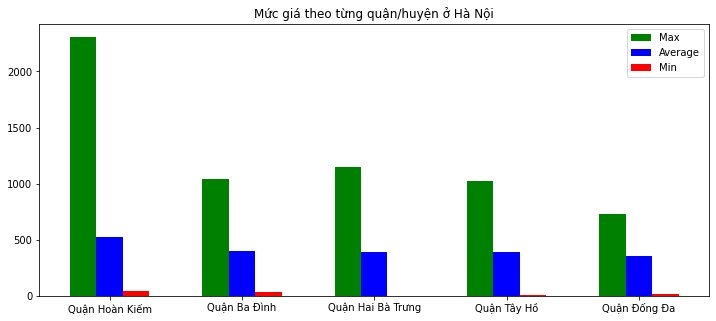

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plot_data = district_price.limit(5).toPandas()
x = list(plot_data['Quận/Huyện'])
ind = np.arange(len(x))

max_value = list(plot_data['Giá trị cao nhất của 1 m^2(triệu VNĐ)'])
min_value = list(plot_data['Giá trị thấp nhất của 1 m^2(triệu VNĐ)'])
average_value = list(plot_data['Giá trị trung bình của 1 m^2(triệu VNĐ)'])

w = 0.2
ax = plt.figure(figsize = (12, 5))
#ax.bar(ind-0.3, max_value, width=0.2, color='b', align='center')
plt.bar(ind-w, max_value, width=0.2, color='g', align='center', label = "Max")
plt.bar(ind, average_value, width=0.2, color='b', align='center', label = "Average")
plt.bar(ind+w, min_value, width=0.2, color='r', align='center', label = "Min")
plt.title("Mức giá theo từng quận/huyện ở Hà Nội")
plt.xticks(ind, x)
plt.legend()
plt.show()
#plt.autoscale(tight=True)
#ax.set_xticklabels(x)

In [ ]:
round(float(1.0/10),1)

0.1

In [ ]:
### Save analysis file
district_price.toPandas().to_csv("district_price_analysis.csv")

# Analysis description

In [ ]:
# Các chủ đầu tư tham gia vào nhiều dự án nhất
investors_df= df.groupby("Chủ đầu tư")\
                .agg(func.sum("Diện tích").alias("Tổng diện tích đất giao bán(m^2)"),\
                     func.sum("Mức giá").alias("Tổng giá trị đất giao bán(nghìn tỉ VNĐ)"),\
                     func.count("Chủ đầu tư").alias("Số dự án tham gia"))
investors_df = investors_df\
               .withColumn("Tổng diện tích đất giao bán(m^2)", func.round(investors_df["Tổng diện tích đất giao bán(m^2)"], 2))\
               .withColumn("Tỉ lệ tham gia dự án(%)", func.col("Số dự án tham gia")/func.sum("Số dự án tham gia").over(Window.partitionBy())*100)\
               .withColumn("Tổng giá trị đất giao bán(nghìn tỉ VNĐ)", investors_df["Tổng giá trị đất giao bán(nghìn tỉ VNĐ)"]/1000000)
investors_df = investors_df\
               .withColumn("Tỉ lệ tham gia dự án(%)", func.round(investors_df["Tỉ lệ tham gia dự án(%)"], 2))\
               .withColumn("Tổng giá trị đất giao bán(nghìn tỉ VNĐ)", func.round(investors_df["Tổng giá trị đất giao bán(nghìn tỉ VNĐ)"], 2))

In [ ]:
investors_df.sort("Số dự án tham gia", ascending=False)\
            .show()

+--------------------+--------------------------------+---------------------------------------+-----------------+-----------------------+
|          Chủ đầu tư|Tổng diện tích đất giao bán(m^2)|Tổng giá trị đất giao bán(nghìn tỉ VNĐ)|Số dự án tham gia|Tỉ lệ tham gia dự án(%)|
+--------------------+--------------------------------+---------------------------------------+-----------------+-----------------------+
|   Tập đoàn Vingroup|                       687775.76|                                  75.68|             5025|                   9.37|
|      Novaland Group|                       261552.11|                                  17.95|             2508|                   4.68|
|Công ty CP Tập đo...|                       192582.03|                                   9.08|             2155|                   4.02|
|Công ty TNHH Phát...|                       270770.07|                                   37.9|             1772|                   3.31|
|Tổng Công ty Đầu ...|            

# MLLib

In [ ]:
corr = data.corr()
corr[['Mức giá']].sort_values(by='Mức giá',ascending=False).style.background_gradient(cmap='viridis', axis=None)

,Mức giá
Mức giá,1.000000
Diện tích,0.489584
Đường vào,0.185214
Mặt tiền,0.160617
Số phòng ngủ,0.093217
Số toilet,0.049255
Số tầng,0.011073


In [ ]:
data = data.fillna(-1)
data.head(10)

,Mức giá,Diện tích,Mặt tiền,Đường vào,Số tầng,Số phòng ngủ,Số toilet,Address
0,4100.0,100.0,-1.0,-1.0,2,3,2,Thành phố Thủ Dầu Một (tỉnh lỵ)
1,2350.0,98.0,-1.0,3.0,-1,2,1,Thành phố Thủ Dầu Một (tỉnh lỵ)
2,1800.0,88.5,15.0,3.5,-1,-1,-1,Thành phố Thủ Dầu Một (tỉnh lỵ)
3,7900.0,108.0,-1.0,8.0,4,6,5,Thành phố Thủ Dầu Một (tỉnh lỵ)
4,5200.0,100.0,5.0,8.0,2,3,2,Thành phố Thủ Dầu Một (tỉnh lỵ)
5,4800.0,69.0,5.0,5.0,3,3,3,Thành phố Thủ Dầu Một (tỉnh lỵ)
6,3050.0,64.0,4.0,5.0,2,3,2,Thành phố Thủ Dầu Một (tỉnh lỵ)
7,3900.0,90.5,5.0,6.0,2,3,2,Thành phố Thủ Dầu Một (tỉnh lỵ)
8,3100.0,85.0,5.0,4.0,2,3,2,Thành phố Thủ Dầu Một (tỉnh lỵ)
9,4200.0,60.0,6.0,5.0,2,2,2,Thành phố Thủ Dầu Một (tỉnh lỵ)


Text(0.5, 1.0, 'GarageCars vs SalePrice')

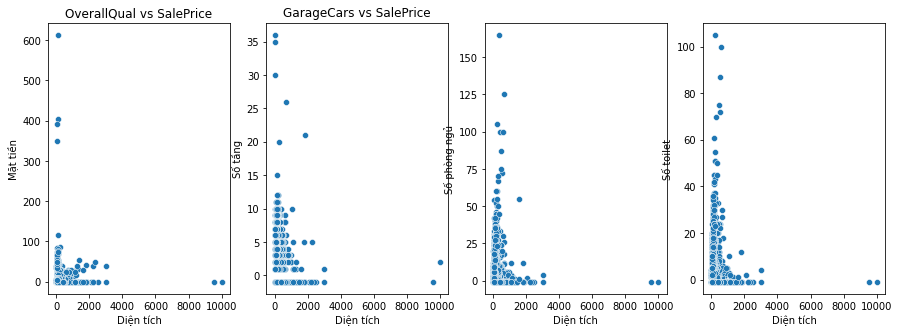

In [ ]:
fig, axes = plt.subplots(1, 4, sharex=True, figsize=(15,5))
#axes[0].set_xlim(0,10)

sns.scatterplot(data=data, ax=axes[0], x='Diện tích', y='Mặt tiền')
axes[0].set_title('OverallQual vs SalePrice')
sns.scatterplot(data=data, ax=axes[1], x='Diện tích', y='Số tầng')
axes[1].set_title('GarageCars vs SalePrice')
sns.scatterplot(data=data, ax=axes[2], x='Diện tích', y='Số phòng ngủ')
axes[1].set_title('GarageCars vs SalePrice')
sns.scatterplot(data=data, ax=axes[3], x='Diện tích', y='Số toilet')
axes[1].set_title('GarageCars vs SalePrice')

In [ ]:
len(data[data['Số toilet']>20])

204

In [ ]:
data= data.drop((data[(data['Mặt tiền']>30) | (data['Diện tích']>1000) | (data['Số phòng ngủ']>20) | (data['Số toilet']>20)].index))

In [ ]:
from sklearn.model_selection import train_test_split

pd_train, pd_test = train_test_split(data, test_size=0.15)

In [ ]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(pd_train['Address'])
pd_train['Address'] = le.transform(pd_train['Address'])
pd_test['Address'] = le.transform(pd_test['Address'])

In [ ]:
train_df = spark.createDataFrame(pd_train)
test_df = spark.createDataFrame(pd_test)

In [ ]:
test_df.show(5)

+-------+---------+--------+---------+-------+------------+---------+-------+
|Mức giá|Diện tích|Mặt tiền|Đường vào|Số tầng|Số phòng ngủ|Số toilet|Address|
+-------+---------+--------+---------+-------+------------+---------+-------+
| 4150.0|     35.0|     4.0|      3.0|      5|           3|        4|      4|
| 4500.0|     51.0|     4.3|      9.0|      2|           2|        2|      3|
| 7600.0|     40.0|    -1.0|     -1.0|      5|          -1|       -1|      9|
| 1800.0|     39.0|     5.0|     -1.0|      3|           3|        3|      0|
|14900.0|     95.0|    -1.0|     -1.0|      5|           6|        8|      3|
+-------+---------+--------+---------+-------+------------+---------+-------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = train_df.drop("Mức giá").columns, outputCol = 'features').setHandleInvalid("keep")

train_vector = vectorAssembler.transform(train_df)

In [ ]:
vectorAssembler2 = VectorAssembler(inputCols = test_df.drop("Mức giá").columns, outputCol = 'features').setHandleInvalid("keep")

test_vector = vectorAssembler2.transform(test_df)

In [ ]:
#from pyspark.ml.feature import StandardScaler
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=False)
scalerModel = scaler.fit(train_vector)
scaled_train = scalerModel.transform(train_vector)

scalerModel2 = scaler.fit(test_vector)
scaled_test = scalerModel2.transform(test_vector)

In [ ]:
scaled_train.show(5)

+-------+---------+--------+---------+-------+------------+---------+-------+--------------------+--------------------+
|Mức giá|Diện tích|Mặt tiền|Đường vào|Số tầng|Số phòng ngủ|Số toilet|Address|            features|      scaledFeatures|
+-------+---------+--------+---------+-------+------------+---------+-------+--------------------+--------------------+
| 6650.0|     82.0|    6.48|      8.0|      4|           4|        5|      3|[82.0,6.48,8.0,4....|[1.55202022030022...|
|19000.0|     64.0|    -1.0|     -1.0|     -1|          -1|       -1|      3|[64.0,-1.0,-1.0,-...|[1.21133285486846...|
| 4100.0|     50.7|    -1.0|     -1.0|     -1|          -1|       -1|     22|[50.7,-1.0,-1.0,-...|[0.95960274596611...|
| 7900.0|     63.0|    -1.0|     -1.0|     -1|           3|       -1|      5|[63.0,-1.0,-1.0,-...|[1.19240577901114...|
| 4500.0|     64.0|    -1.0|      8.0|      3|           4|        4|      3|[64.0,-1.0,8.0,3....|[1.21133285486846...|
+-------+---------+--------+---------+--

In [ ]:
# Simple baseline (linreg)

from pyspark.ml.regression import LinearRegression

lr = LinearRegression(featuresCol = 'scaledFeatures', labelCol='Mức giá', maxIter=10, 
                      regParam=0.8, elasticNetParam=0.1) # It is always a good idea to play with hyperparameters.
lr_model = lr.fit(scaled_train)

trainingSummary = lr_model.summary
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)

lr_predictions = lr_model.transform(scaled_test)
lr_predictions.select("prediction","Mức giá","scaledFeatures").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
lr_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Mức giá",metricName="r2")
print("R Squared (R2) on val data = %g" % lr_evaluator.evaluate(lr_predictions))

RMSE: 7991.678340
r2: 0.421645
+------------------+-------+--------------------+
|        prediction|Mức giá|      scaledFeatures|
+------------------+-------+--------------------+
|  6482.89550297895| 4150.0|[0.67881991248299...|
|  6640.44843632443| 4500.0|[0.98913758676093...|
| 7455.403147846682| 7600.0|[0.77579418569485...|
| 6247.414694413271| 1800.0|[0.75639933105248...|
|14508.477990170839|14900.0|[1.84251119102527...|
+------------------+-------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.463612


In [ ]:
# A more complex model with RF

from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(featuresCol = 'scaledFeatures', labelCol='Mức giá', 
                           maxDepth=20, 
                           minInstancesPerNode=2,
                           bootstrap=True
                          )
rf_model = rf.fit(scaled_train)

rf_predictions = rf_model.transform(scaled_test)
rf_predictions.select("prediction","Mức giá","scaledFeatures").show(5)

from pyspark.ml.evaluation import RegressionEvaluator
rf_evaluator = RegressionEvaluator(predictionCol="prediction", \
                 labelCol="Mức giá",metricName="r2")
print("R Squared (R2) on val data = %g" % rf_evaluator.evaluate(rf_predictions))

+------------------+-------+--------------------+
|        prediction|Mức giá|      scaledFeatures|
+------------------+-------+--------------------+
| 3880.233530758681| 4150.0|[0.67881991248299...|
| 5044.895000000001| 4500.0|[0.98913758676093...|
| 9029.467620124973| 7600.0|[0.77579418569485...|
|2375.8690476190477| 1800.0|[0.75639933105248...|
|15774.916666666666|14900.0|[1.84251119102527...|
+------------------+-------+--------------------+
only showing top 5 rows

R Squared (R2) on val data = 0.625795
